# Tracer Boundary Indexing

A temporal notebook that tests the best location to set tracers' open boundary.

In [1]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [3]:
reload(Nts)

<module 'NEMO_tools' from '_libs/NEMO_tools.pyc'>

#ORCA2

**The part of ORCA need more work**

In [4]:
MAT = scipy.io.loadmat('_data/Exchange/NEMO_ORCA2_Ba.mat')
Ba_ini_orca = MAT['Ba_ini_orca'][:]
nav_lat = MAT['nav_lat'][:]
nav_lon = MAT['nav_lon'][:]

MAT = scipy.io.loadmat('_data/Exchange/NEMO_ORCA2_d18O.mat')
d18O_ini_orca = MAT['d18O_ini_orca'][:]
nav_lat = MAT['nav_lat'][:]
nav_lon = MAT['nav_lon'][:]

In [5]:
Ba_ini_orca.shape

(31, 149, 182)

In [6]:
field = np.zeros([31, 149, 182])
domain = np.zeros(nav_lon.shape)
Ba_boundary = np.zeros([31, 149, 182])
d18O_boundary = np.zeros([31, 149, 182])

In [7]:
domain[~np.isnan(Ba_ini_orca[0, :, :])]=1.0

In [8]:
for i in range(182):
    for j in range(148):
        for k in range(31):
            if (np.isnan(Ba_ini_orca[k, j, i]) and (~np.isnan(Ba_ini_orca[k, j+1, i]))):
                field[k, j+1, i] = 1.0
                field[k, j  , i] = 1.0
                field[k, j-1, i] = 1.0

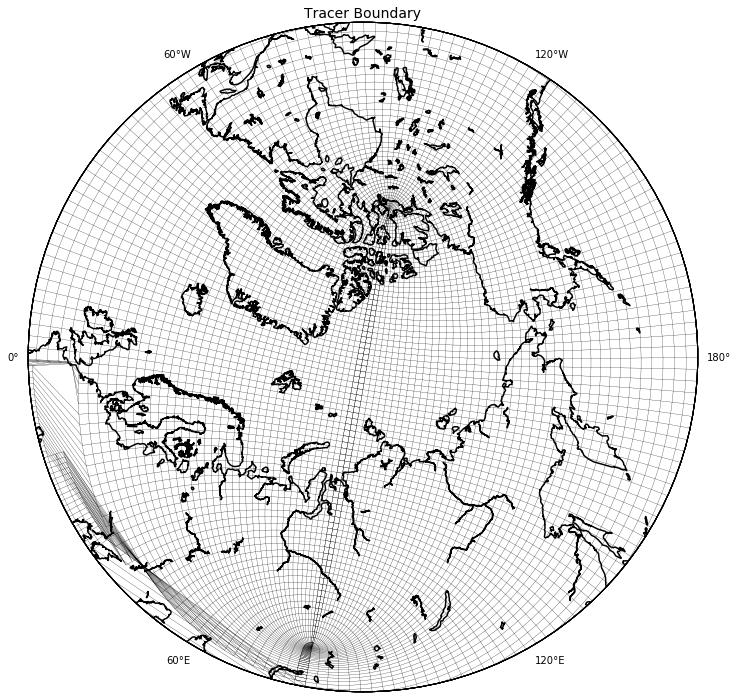

In [9]:
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(nav_lon, nav_lat)
proj.pcolor(x, y, field[1, :, :], cmap=plt.cm.gray_r)
proj.plot(x, y, 'k-', linewidth=0.25)#, alpha=0.25);
proj.plot(x.T, y.T, 'k-', linewidth=0.25)#, alpha=0.25)
#proj.plot(x[135, -48], y[135, -48], 'ro', ms=12)
ax.set_title('Tracer Boundary', fontsize=14)
plt.show()
#fig.savefig('Publish/Barium_boundary.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0)

In [10]:
for i in range(182):
    for j in range(149):
        for k in range(31):
            if (field[k, j, i]==1):
                Ba_boundary[k, j, i] = Ba_ini_orca[k, j, i]
                d18O_boundary[k, j, i] = d18O_ini_orca[k, j, i]
            else:
                Ba_boundary[k, j, i] = -999.9
                d18O_boundary[k, j, i] = -999.9

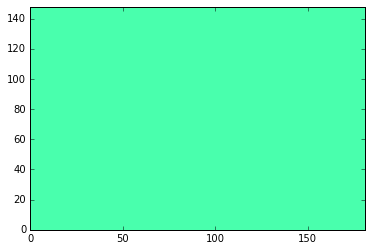

In [11]:
#plt.contourf(d18O_ini_orca[2, :, :])
plt.contourf(field[0, :, :])

In [12]:
save_var = { 'Ba': Ba_boundary, 'd18O': d18O_boundary, 'domain': domain}
scipy.io.savemat('_data/Exchange/TRC_BOUND.mat', mdict=save_var)

#ANHA4

In [13]:
ANHA4_MAT = scipy.io.loadmat('_data/Exchange/NEMO_ANHA4_Ba.mat')
Ba_ini_ANHA4 = ANHA4_MAT['Ba_ini_ANHA4'][:]
nav_lat = ANHA4_MAT['nav_lat'][:]
nav_lon = ANHA4_MAT['nav_lon'][:]

In [14]:
nav_lat.shape

(544, 800)

In [15]:
domain_ANHA4 = np.zeros(nav_lon.shape)
field_ANHA4 = np.zeros([50, 544, 800])

In [16]:
BOUND = 60.0
for i in range(544):
    for j in range(800):
        if (nav_lat[i, j] > BOUND):
            domain_ANHA4[i, j] = 1.0
            if (nav_lat[i, j-1] < BOUND):
                domain_ANHA4[i, j:j-4] = 0.0
                for k in range(50):
                    field_ANHA4[k, i, j:j+5] = Ba_ini_ANHA4[k, i, j:j+5]
field_ANHA4[:, :, 797:800] = Ba_ini_ANHA4[:, :, 797:800]

In [17]:
#fake_domain = np.zeros(domain_ANHA4.shape)
#fake_domain = np.ma.masked_where(domain_ANHA4==1, fake_domain)
#fake_domain = fake_domain[nav_lat>45.5]
domain_ANHA4[field_ANHA4[0, :, :]>0.5] = 2.0

/home/yingkai/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/yingkai/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


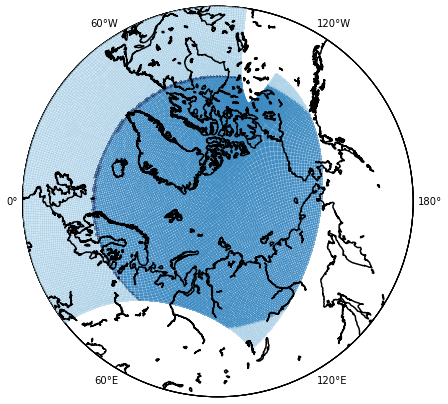

In [18]:
fig=plt.figure(figsize=(7, 7)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color='k', lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k', zorder=4)
x, y = proj(nav_lon, nav_lat)
CS=proj.pcolor(x[::3, ::3], y[::3, ::3], domain_ANHA4[::3, ::3], cmap=plt.cm.Blues, vmin=-1, vmax=2, zorder=2, alpha=0.5)
#proj.pcolor(x, y, field_ANHA4[0, :, :], cmap=plt.cm.gray_r) # field_ANHA4[0, :, :]
#proj.plot(x, y, 'k-', linewidth=0.25, zorder=2)#, alpha=0.25);
#proj.plot(y.T, y.T, 'k-', linewidth=0.25)#, alpha=0.25)
#proj.pcolor(x, y, fake_domain, vmax=999, cmap=plt.cm.gray_r, zorder=3)
#ax.set_title('Tracer Boundary (ANHA4)', fontsize=14)
#plt.show()
#fig.savefig('open_boundary_SMALL.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0.1)

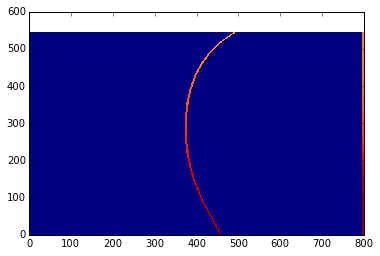

In [19]:
plt.pcolor(field_ANHA4[0, :, :])

In [22]:
#save_var = { 'Ba_boundary': field_ANHA4, 'domain': domain_ANHA4}
#scipy.io.savemat('_data/Exchange/Ba_boundary_ANHA4.mat', mdict=save_var)